#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все необходимые библиотеки и структуры. Загрузим и изучим данные.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.index.is_monotonic

True

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
print('Наличие пропусков', data.isnull().sum())

Наличие пропусков num_orders    0
dtype: int64


In [8]:
print('Наличие дубликатов', data.duplicated().sum())

Наличие дубликатов 26415


In [9]:
duplicated_taxi = data[data.duplicated()].head()
duplicated_taxi

,num_orders
datetime,
2018-03-01 02:10:00,12
2018-03-01 02:20:00,19
2018-03-01 03:00:00,8
2018-03-01 03:10:00,17
2018-03-01 03:20:00,7


In [10]:
data.index.duplicated().sum()

0

Скорее всего это не дубликаты, а просто совпадения по дате и времени заказов. Т.е. заказ такси в одно и то же время.

**Вывод по 1 шагу**

На первом шаге произведена загрузка и изучение данных.

1. Перед нами DataFrame, содержащий информацию о времени и количестве заказов в компании «Чётенькое такси».
2. Пропусков и дубликатов нет. 
3. Данные отсортированы в хронологическом порядке. 
4. В DataFrame данные за период с 1 марта 2018 по 31 августа 2018 года.

Данные готовы к дальнейшему изучению.

## Анализ

Выполним ресемплирование данных по одному часу.

<AxesSubplot:xlabel='datetime'>

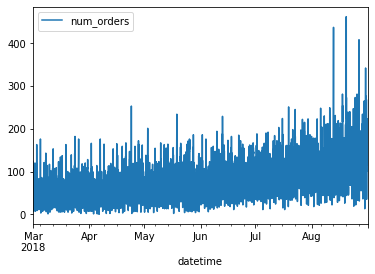

In [11]:
data = data.resample('1H').sum()
data.plot()

Посмотрим на информацию за последние 2 недели.

<AxesSubplot:xlabel='datetime'>

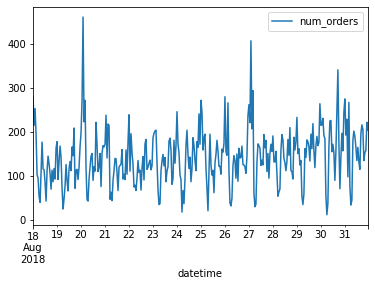

In [12]:
data['2018-08-18':'2018-08-31'].plot()

Рассмотрим тренды и сезонность всего датафрейма.

In [13]:
decomposed = seasonal_decompose(data)

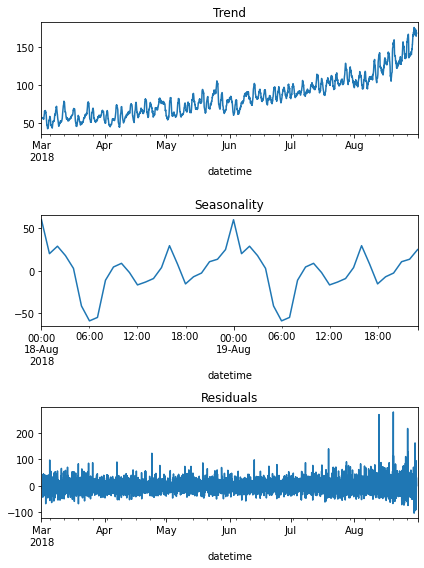

In [14]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-08-18':'2018-08-19'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Рассмотрим тренды и сезонность за последние 2 недели.

In [15]:
decomposed_w = seasonal_decompose(data['2018-08-18':'2018-08-31'])

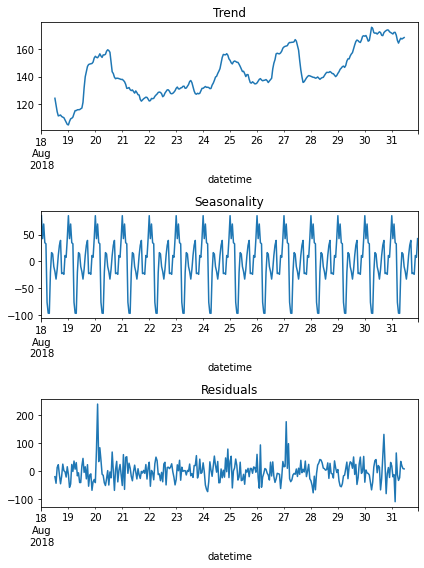

In [16]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed_w.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_w.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed_w.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

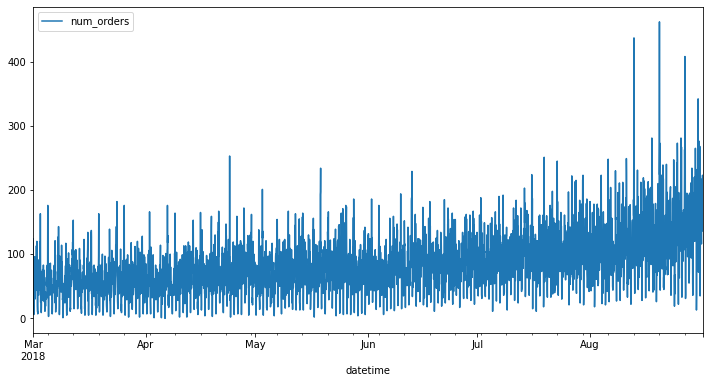

In [17]:
data.plot(figsize=(12, 6))

Чтобы сделать данные стационарными, вычеслим разность временного ряда.

In [18]:
data = data - data.shift()
data.dropna(inplace=True)

<AxesSubplot:xlabel='datetime'>

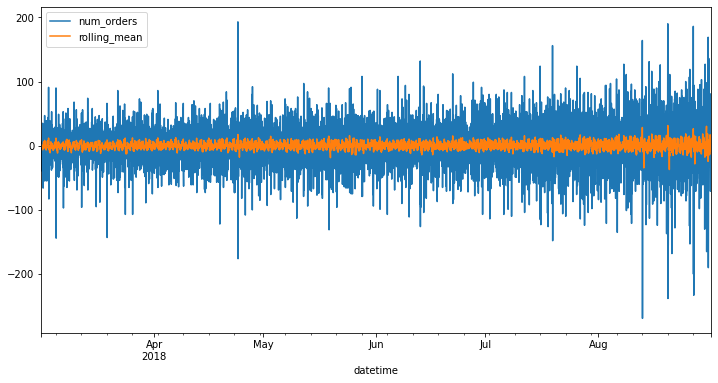

In [19]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot(figsize=(12, 6))

Создадим признаки для обучения моделей.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 24)
print(data.head())

                     num_orders  rolling_mean  dayofweek  hour  lag_1  lag_2  \
datetime                                                                       
2018-03-01 01:00:00       -39.0           NaN          3     1    NaN    NaN   
2018-03-01 02:00:00       -14.0           NaN          3     2  -39.0    NaN   
2018-03-01 03:00:00        -5.0           NaN          3     3  -14.0  -39.0   
2018-03-01 04:00:00       -23.0           NaN          3     4   -5.0  -14.0   
2018-03-01 05:00:00       -37.0           NaN          3     5  -23.0   -5.0   

                     lag_3  lag_4  lag_5  lag_6  ...  lag_15  lag_16  lag_17  \
datetime                                         ...                           
2018-03-01 01:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 04:00:00  -39.0    NaN    Na

**Вывод по 2 шагу**

Проведено ресемплироание по одному часу, изучены тренды и сезонность, созданы признаки для обучения.

## Обучение

Разделим выборку на train, valid и test, тестовую выборку сделаем размером 10% от исходных данных.

In [21]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

Посмотрим на минимальные и максимальные значения индексов выборок. Убедимся в корректности деления.

In [22]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 01:00:00 2018-07-28 02:00:00
2018-07-28 03:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [23]:
print(train.shape)
print(valid.shape)
print(test.shape)

(3554, 28)
(395, 28)
(442, 28)


Разделим выборки train и test на features_train, target_train, features_valid, target_valid, features_test и target_test.

In [24]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

Для удобства создадим функцию для определения RMSE. 

In [25]:
def RMSE(target, predict):
    RMSE = (mean_squared_error(target, predict))**0.5
    return RMSE

score = make_scorer(RMSE, greater_is_better=False)

Перейдем к обучению моделей.

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
%%time
const_model = DummyRegressor(strategy="mean")
const_model.fit(features_train, target_train)
predicted_const_model = const_model.predict(features_valid)
RMSE_const_model = mean_squared_error(target_valid, predicted_const_model)**0.5 
print('RMSE DummyRegressor на валидационной выборке:', RMSE_const_model)

RMSE DummyRegressor на валидационной выборке: 47.24948326892598
CPU times: user 1.16 ms, sys: 312 µs, total: 1.47 ms
Wall time: 1.15 ms


In [28]:
%%time
model_dtr = DecisionTreeRegressor(random_state=42)

RMSE_dtr = cross_val_score(model_dtr, features_train, target_train, scoring=score, cv=tscv)
RMSE_dtr = pd.Series(RMSE_dtr).mean()*(-1)
print('RMSE DecisionTreeRegressor на валидационной выборке:', RMSE_dtr)

RMSE DecisionTreeRegressor на валидационной выборке: 35.90368097571887
CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 198 ms


In [29]:
%%time

model_lr = LinearRegression() 

RMSE_lr = cross_val_score(model_lr, features_train, target_train, scoring=score, cv=tscv)
RMSE_lr = pd.Series(RMSE_lr).mean()*(-1)
print('RMSE LinearRegression на валидационной выборке:', RMSE_lr)

RMSE LinearRegression на валидационной выборке: 26.021724350344705
CPU times: user 107 ms, sys: 238 ms, total: 345 ms
Wall time: 338 ms


In [30]:
%%time

model_rfr = RandomForestRegressor(random_state=42) 
forest_parametrs = {'n_estimators': range(5, 20),
                     'max_depth': range(1, 5)}
grid = GridSearchCV(model_rfr, forest_parametrs, cv=tscv)
grid.fit(features_train, target_train) 
predictions_valid = grid.predict(features_valid)
RMSE_rfr = mean_squared_error(target_valid, predictions_valid)**0.5 
print("RMSE наилучшей модели на валидационной выборке:", RMSE_rfr)

RMSE наилучшей модели на валидационной выборке: 38.14809935309211
CPU times: user 16.2 s, sys: 77.9 ms, total: 16.3 s
Wall time: 16.4 s


In [31]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 14}

In [32]:
%%time

model_cat = CatBoostRegressor(random_state=42)
params = {'iterations': [150,200],
          'depth': [3,5],
          'loss_function': ['RMSE']}

grid_cat = GridSearchCV(model_cat, params, cv=tscv)
grid_cat.fit(features_train, target_train) 
predictions_valid = grid_cat.predict(features_valid)
RMSE_grid_cat = mean_squared_error(target_valid, predictions_valid)**0.5 
print("RMSE CatBoostRegressor на валидационной выборке:", RMSE_grid_cat)

Learning rate set to 0.176309
0:	learn: 28.1722642	total: 47.4ms	remaining: 7.06s
1:	learn: 27.1761351	total: 48.5ms	remaining: 3.59s
2:	learn: 26.4869090	total: 49.3ms	remaining: 2.41s
3:	learn: 26.0025206	total: 50.2ms	remaining: 1.83s
4:	learn: 25.1692173	total: 50.9ms	remaining: 1.48s
5:	learn: 24.4405763	total: 51.7ms	remaining: 1.24s
6:	learn: 24.1508604	total: 52.4ms	remaining: 1.07s
7:	learn: 23.7724067	total: 53.2ms	remaining: 944ms
8:	learn: 23.4160413	total: 53.9ms	remaining: 845ms
9:	learn: 23.1790371	total: 54.6ms	remaining: 765ms
10:	learn: 22.7989076	total: 55.3ms	remaining: 699ms
11:	learn: 22.5248987	total: 56ms	remaining: 645ms
12:	learn: 22.1650976	total: 56.8ms	remaining: 599ms
13:	learn: 21.8031237	total: 57.6ms	remaining: 559ms
14:	learn: 21.6032961	total: 58.3ms	remaining: 525ms
15:	learn: 21.4999033	total: 59ms	remaining: 494ms
16:	learn: 21.3009317	total: 59.7ms	remaining: 467ms
17:	learn: 21.1419358	total: 60.4ms	remaining: 443ms
18:	learn: 20.9537838	total: 6

In [33]:
grid_cat.best_params_

{'depth': 5, 'iterations': 200, 'loss_function': 'RMSE'}

In [34]:
%%time
model_lgbmr = LGBMRegressor(random_state=42)
model_lgbmr.fit(features_train, target_train)
predict_lgbmr = model_lgbmr.predict(features_valid)
rmse_lgbmr = mean_squared_error(target_valid, predict_lgbmr)**0.5
print('RMSE LGBMRegressor на валидационной выборке:', rmse_lgbmr)

RMSE LGBMRegressor на валидационной выборке: 33.91135340357489
CPU times: user 939 ms, sys: 0 ns, total: 939 ms
Wall time: 889 ms


In [35]:
columns = ['Название модели', 'RMSE valid']
const_model = ['DummyRegressor', RMSE_const_model]
model_dtr = ['DecisionTreeRegressor', RMSE_dtr]
model_lr = ['LinearRegression', RMSE_lr]
model_rfr = ['RandomForestRegressor', RMSE_rfr]
grid_cat = ['CatBoostRegressor', RMSE_grid_cat]
model_lgbm = ['LGBMRegressor', rmse_lgbmr]

table = pd.DataFrame([const_model, model_dtr, model_lr, model_rfr, grid_cat, model_lgbm], columns = columns)
print('Таблица 1 "RMSE моделей на валидационной выборке"')
display(table)

Таблица 1 "RMSE моделей на валидационной выборке"


,Название модели,RMSE valid
0,DummyRegressor,47.249483
1,DecisionTreeRegressor,35.903681
2,LinearRegression,26.021724
3,RandomForestRegressor,38.148099
4,CatBoostRegressor,32.952911
5,LGBMRegressor,33.911353


**Вывод по 3 шагу**

Проведено обучение моделей, в таблице 1 представлены результаты RMSE на валидационной выборке.
Наилучшие результаты на этом шаге показывают LinearRegression и CatBoostRegressor.

## Тестирование

Проведем тестирование моделей и определим RMSE на тестовой выборке.

In [36]:
%%time
const_model = DummyRegressor(strategy='mean')

const_model.fit(features_train_valid, target_train_valid)
predicted_const_model = const_model.predict(features_test)
RMSE_const_model_test = mean_squared_error(target_test, predicted_const_model)**0.5 
print('RMSE DummyRegressor:', RMSE_const_model_test)

RMSE DummyRegressor: 58.85646242407813
CPU times: user 1.39 ms, sys: 80 µs, total: 1.47 ms
Wall time: 1.19 ms


In [37]:
%%time
model_dtr_test = DecisionTreeRegressor(random_state=42)

RMSE_dtr_test = cross_val_score(model_dtr_test, features_test, target_test, scoring=score, cv=tscv)
RMSE_dtr_test = pd.Series(RMSE_dtr_test).mean()*(-1)
print('RMSE DecisionTreeRegressor на валидационной выборке:', RMSE_dtr_test)

RMSE DecisionTreeRegressor на валидационной выборке: 67.82825827177322
CPU times: user 37.5 ms, sys: 88 µs, total: 37.6 ms
Wall time: 36.8 ms


In [38]:
%%time

model_lr_test = LinearRegression()

model_lr_test.fit(features_train_valid, target_train_valid)
pred = model_lr_test.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, pred)**0.5
print('RMSE LinearRegression на тестовой выборке:', rmse_lr_test)

RMSE LinearRegression на тестовой выборке: 45.07016268605487
CPU times: user 8.27 ms, sys: 82.4 ms, total: 90.7 ms
Wall time: 52.5 ms


In [39]:
%%time
forest_model = RandomForestRegressor(max_depth=4, n_estimators=10, random_state=42)

forest_model.fit(features_train_valid, target_train_valid)
predicted_forest_model = forest_model.predict(features_test)
RMSE_rfr_test = mean_squared_error(target_test, predicted_forest_model)**0.5 
print('RMSE RandomForestRegressor на тестовой выборке:', RMSE_rfr_test)

RMSE RandomForestRegressor на тестовой выборке: 49.80636598149516
CPU times: user 145 ms, sys: 32.3 ms, total: 178 ms
Wall time: 217 ms


In [40]:
%%time
cat_model = CatBoostRegressor(depth=5, iterations=200, loss_function='RMSE')

cat_model.fit(features_train_valid, target_train_valid, verbose=False)
predict_cat = cat_model.predict(features_test)
RMSE_cat_test = mean_squared_error(target_test, predict_cat)**0.5
print('RMSE CatBoostRegressor на тестовой выборке:', RMSE_cat_test)

RMSE CatBoostRegressor на тестовой выборке: 41.182384204026384
CPU times: user 674 ms, sys: 15.4 ms, total: 690 ms
Wall time: 1.16 s


In [41]:
%%time
model = LGBMRegressor(random_state=42)

model.fit(features_train_valid, target_train_valid)
predict_lgb = model.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, predict_lgb)**0.5
print('RMSE LGBMRegressor на тестовой выборке:', rmse_lgb_test)

RMSE LGBMRegressor на тестовой выборке: 43.16173274736268
CPU times: user 993 ms, sys: 6.41 ms, total: 999 ms
Wall time: 1.01 s


In [42]:
columns = ['Название модели', 'RMSE valid', 'RMSE test']
const_model = ['DummyRegressor', RMSE_const_model, RMSE_const_model_test]
model_dtr = ['DecisionTreeRegressor', RMSE_dtr, RMSE_dtr_test]
model_lr = ['LinearRegression', RMSE_lr, rmse_lr_test]
model_rfr = ['RandomForestRegressor', RMSE_rfr, RMSE_rfr_test]
model_cat = ['CatBoostRegressor', RMSE_grid_cat, RMSE_cat_test]
model_lgbm = ['LGBMRegressor', rmse_lgbmr, rmse_lgb_test]

table = pd.DataFrame([const_model, model_dtr, model_lr, model_rfr, model_cat, model_lgbm], columns = columns)
print('Таблица 2 "Сравнение RMSE моделей на валидационной и тестовой выборке"')
display(table)

Таблица 2 "Сравнение RMSE моделей на валидационной и тестовой выборке"


,Название модели,RMSE valid,RMSE test
0,DummyRegressor,47.249483,58.856462
1,DecisionTreeRegressor,35.903681,67.828258
2,LinearRegression,26.021724,45.070163
3,RandomForestRegressor,38.148099,49.806366
4,CatBoostRegressor,32.952911,41.182384
5,LGBMRegressor,33.911353,43.161733


**Вывод по 4 шагу**

Проведено тестирование моделей на тестовой выборке, результаты RMSE представлены в таблице 2.

**Общий вывод**

На первом шаге произведена загрузка и изучение данных.  
На втором шаге проведена подготовка данных для дальнейшего обучения моделей. Проведено ресемплирование по одному часу, вычислена разность временного ряда, добавлены признаки для обучения моделей.
На третьем шаге проведено обучение, подбораны гиперпараметры.   
На четвертом шаге проведено проверка моделей на адекватность, оценка RMSE на тестовой выборке.   


С учетом полученных результатов для построения модели прогнозирования количество заказов такси на следующий час, рекомендовано использовать CatBoostRegressor.  

Значение метрики RMSE на тестовой выборке у CatBoostRegressor и LGBMRegressor не больше 48.